In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py
from platform import python_version
from pylab import rcParams

print(python_version())
print(tf.__version__)

3.7.12
2.7.0


In [17]:
rcParams['figure.figsize'] = (10, 6) 

In [18]:
train_url = 'https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TRAIN.tsv'
test_url = 'https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TEST.tsv'

train_data = np.genfromtxt(train_url, delimiter='\t')
test_data = np.genfromtxt(test_url, delimiter='\t')

print('Training Data:', train_data.shape)
print('Testing Data:', test_data.shape)


Training Data: (3601, 501)
Testing Data: (1320, 501)


In [19]:
train_data[:5]

array([[-1.        , -0.79717168, -0.66439208, ..., -0.66439208,
        -1.0737958 , -1.5643427 ],
       [ 1.        ,  0.80485472,  0.63462859, ..., -0.71488505,
        -0.56044294, -0.31908642],
       [-1.        ,  0.7279851 ,  0.11128392, ...,  0.39446303,
         0.33940042,  0.25539062],
       [-1.        , -0.23443909, -0.50215697, ..., -0.47879007,
        -0.18870673,  0.11973631],
       [-1.        , -0.17132785, -0.06228531, ...,  0.43751994,
        -0.02658494, -0.60221303]])

In [20]:
test_data[:5]

array([[-1.        , -0.14040239,  0.17164128, ..., -0.69040244,
        -0.97659635, -0.79426313],
       [-1.        ,  0.33403756,  0.32225332, ..., -1.0417721 ,
        -1.1596145 , -1.3756589 ],
       [-1.        ,  0.71668608,  0.74436655, ..., -3.6752806 ,
        -4.1366217 , -4.3396117 ],
       [ 1.        ,  1.2402825 ,  1.3311892 , ..., -0.93122241,
        -0.93449835, -1.0012878 ],
       [-1.        , -1.1594784 , -1.2041741 , ...,  0.00898714,
         0.13141252,  0.18626624]])

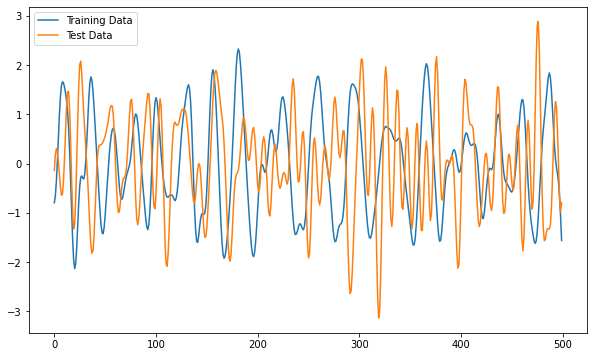

In [21]:
plt.plot(train_data[0,1:], label='Training Data')
plt.plot(test_data[0,1:], label='Test Data')
plt.legend()
plt.show()

In [22]:
x_train = train_data[:, 1:]
y_train = train_data[:, 0]
x_test = test_data[:, 1:]
y_test = test_data[:, 0]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3601, 500)
(3601,)
(1320, 500)
(1320,)


In [23]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(2880, 500)
(2880,)
(721, 500)
(721,)


In [24]:
x_train = x_train[:,:,np.newaxis]
x_val = x_val[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2880, 500, 1)
(721, 500, 1)
(1320, 500, 1)


In [25]:
num_classes = len(np.unique(y_train))
num_classes

2

In [26]:
y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)
y_test = np.where(y_test == -1, 0, y_test)

print(y_train[:5])
print(y_val[:5])
print(y_test[:5])

[0. 1. 1. 0. 1.]
[1. 1. 0. 0. 1.]
[0. 0. 0. 1. 0.]


In [27]:
model = Sequential([
                    layers.Input(shape=([500, 1])),
                    layers.Conv1D(32, kernel_size=3, activation='relu'),
                    layers.MaxPool1D(2,2),
                    layers.Conv1D(64, kernel_size=3, activation='relu'),
                    layers.MaxPool1D(2,2),
                    layers.Conv1D(64, kernel_size=3, activation='relu'),
                    layers.MaxPool1D(2,2),
                    layers.Flatten(),
                    layers.Dropout(0.2),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 498, 32)           128       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 249, 32)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 247, 64)           6208      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 123, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 121, 64)           12352     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 60, 64)          

In [28]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('val_accuracy') > 0.9:
      print('\nTarget accuracy reached, training stopped...')
      self.model.stop_training = True

best_model = keras.callbacks.ModelCheckpoint(
    'best_model.h5', save_best_only=True, monitor='val_loss'
)

callbacks = [myCallback(), best_model]

In [29]:
epochs = 500
batch_size = 64

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=1e-3), 
              metrics=['accuracy']
              )

history = model.fit(x_train,
          y_train,
          shuffle=True,
          validation_data=(x_val, y_val),
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[callbacks])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


45/45 [==============================] - 1s 12ms/step - loss: 0.6697 - accuracy: 0.5646 - val_loss: 0.5816 - val_accuracy: 0.6449
Epoch 2/500
45/45 [==============================] - 0s 8ms/step - loss: 0.5000 - accuracy: 0.7413 - val_loss: 0.3772 - val_accuracy: 0.8474
Epoch 3/500
45/45 [==============================] - 0s 7ms/step - loss: 0.3418 - accuracy: 0.8458 - val_loss: 0.2935 - val_accuracy: 0.8738
Epoch 4/500
45/45 [==============================] - 0s 6ms/step - loss: 0.2617 - accuracy: 0.8875 - val_loss: 0.2609 - val_accuracy: 0.8918
Epoch 5/500
45/45 [==============================] - 0s 6ms/step - loss: 0.2419 - accuracy: 0.8938 - val_loss: 0.3077 - val_accuracy: 0.8613
Epoch 6/500
45/45 [==============================] - 0s 7ms/step - loss: 0.2237 - accuracy: 0.9066 - val_loss: 0.2497 - val_accuracy: 0.8988
Epoch 7/500
42/45 [===========================>..] - ETA: 0s - loss: 0.1893 - accuracy: 0.9226
Target accuracy reached, training stopped...
45/45 [==================

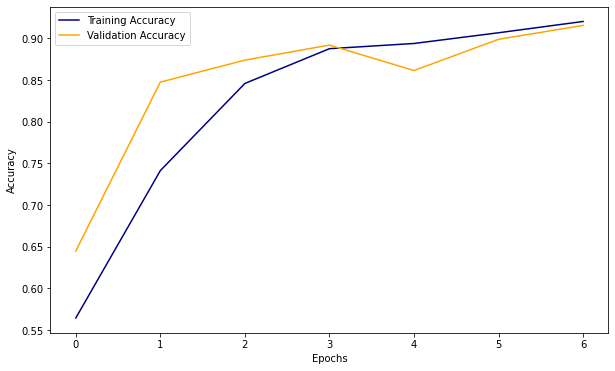

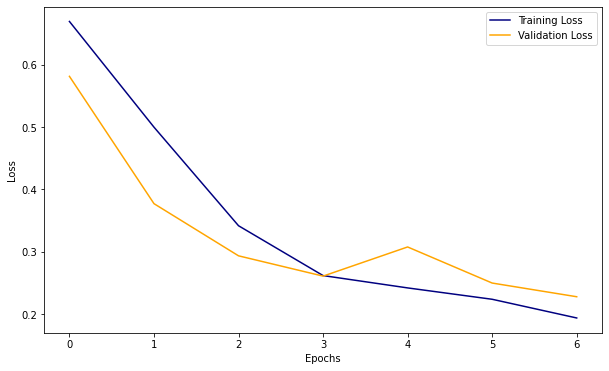

In [30]:
def plot_graphs(history, string):
  plt.figure()
  plt.plot(history.history[string], 'navy', label=f'Training {string.title()}')
  plt.plot(history.history['val_'+string], 'orange', label=f'Validation {string.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(string.title())
  plt.legend()
  return plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [31]:
loaded_model = keras.models.load_model('best_model.h5')

test_loss, test_acc = loaded_model.evaluate(x_test, y_test)

print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

42/42 [==============================] - 0s 3ms/step - loss: 0.2403 - accuracy: 0.9038
Test Accuracy: 0.9037878513336182
Test Loss: 0.24027235805988312
